In [44]:
from collections.abc import Callable
from __future__ import annotations
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import numpy as np
import abc


# Handy type alias
FArray = NDArray[np.float64]


# Function
## Initialize the domain and initial condition.
class Initialize(abc.ABC):
    @abc.abstractmethod
    def initialize(nx: int, L: float) -> tuple[FArray, FArray, float]:
        pass


class GaussionInitialize(Initialize):
    def initialize(self, nx: int, L: float) -> tuple[FArray, FArray, float]:
        dx = L / (nx - 1)
        x = np.linspace(0, L, nx)
        u_initial = np.exp(-100 * (x - 0.5 * L) ** 2)
        return x, u_initial, dx
    
class SinusoidalInitialize(Initialize):
    def initialize(self, nx: int, L: float) -> tuple[FArray, FArray, float]:
        dx = L / (nx - 1)
        x = np.linspace(0, L, nx)
        u_initial = np.sin(2 * np.pi * x / L)
        return x, u_initial, dx


## Apply boundary conditions with periodic boundary condition.
def apply_boundary_conditions(u: FArray) -> FArray:
    u[0] = u[-2]
    u[-1] = u[1]
    return u


## Calculate viscous term with central differential method
def compute_second_derivative(u: FArray, dx: float) -> FArray:
    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx ** 2
    u_xx = apply_boundary_conditions(u_xx)
    return u_xx


# Numerical methods class
class NumericalMethod(abc.ABC):
    @abc.abstractmethod
    def __call__(self, u: FArray, dx: float, nu: float) -> FArray:
        pass


# Finite Difference Method class
class FDMMethod(NumericalMethod):
    def __call__(self, u: FArray, dx: float, nu: float) -> FArray:
        rhs = np.zeros_like(u)
        rhs = -0.5 * (u * (np.roll(u, -1) - np.roll(u, +1))) / dx
        rhs += nu * compute_second_derivative(u, dx)
        rhs = apply_boundary_conditions(rhs)
        return rhs

# Finite Volume Method class
class FVMMethod(NumericalMethod):
    def __call__(self, u: FArray, dx: float, nu: float) -> FArray:
        rhs = np.zeros_like(u)
        rhs = -((np.roll(u, -1)) ** 2 - (np.roll(u, +1)) ** 2) / (2 * dx)
        rhs += nu * compute_second_derivative(u, dx)
        rhs = apply_boundary_conditions(rhs)
        return rhs


# Time integrator class
class IntegratorBase(abc.ABC):
    @abc.abstractmethod
    def compute_step(
        self,
        method: NumericalMethod,
        t_n: float,
        y_n: FArray,
        h: float,
    ) -> FArray:
        pass

    def integrate(
        self,
        initializer: Initialize,
        method: NumericalMethod,
        nx: int,
        L: float,
        nu: float,
        nt: int,
    ) -> FArray:
        x, u_initial, dx = initializer.initialize(nx, L)
        u = u_initial.copy()

        for _ in range(nt):
            u = self.compute_step(method, nu, u, dx)

        return u


class EulerIntegrator(IntegratorBase):
    def compute_step(
        self,
        method: NumericalMethod,
        nu: float,
        u: FArray,
        dx: float,
    ) -> FArray:
        # Compute dydt based on *current* position
        dydt = method(u, dx, nu)
        u += dydt * dx
        u = apply_boundary_conditions(u)
        # Return next velocity and position
        return u


class RK2Integrator(IntegratorBase):
    def compute_step(
        self,
        method: NumericalMethod,
        nu: float,
        u: FArray,
        dx: float,
    ) -> FArray:
        # Compute k1 through k4
        k1 = dx * method(u, dx, nu)
        k2 = dx * method(u + k1, dx, nu)

        result: FArray = u + 0.5 * (k1 + k2)
        return result


class RK4Integrator(IntegratorBase):
    def compute_step(
        self,
        method: NumericalMethod,
        nu: float,
        u: FArray,
        dx: float,
    ) -> FArray:
        # Compute k1 through k4
        k1 = dx * method(u, dx, nu)
        k2 = dx * method(u + k1 / 2, dx, nu)
        k3 = dx * method(u + k2 / 2, dx, nu)
        k4 = dx * method(u + k3, dx, nu)

        # Specifying static type here because mypy + numpy
        # loses track over multiple operations sometimes
        result: FArray = u + (1 / 6) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        return result

Comparison between FVMMethod and FDMMethod (EulerIntegrator, nt = 5)

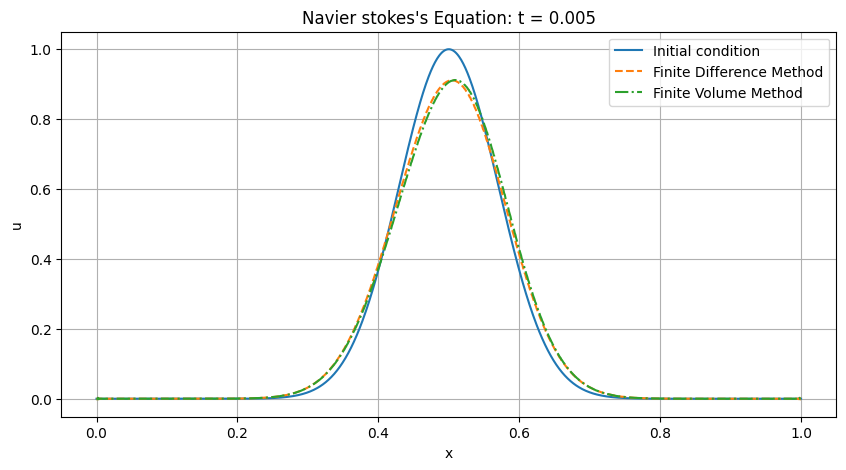

In [60]:
# Problem inputs
## Set the basic parameter
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nt = 5              # Time steps
tlim = dt * nt      # End time for simulation
nu = 0.1            # Viscosity

## Set the initial condition
dx = L / (nx - 1)
x, u_initial, dx = GaussionInitialize().initialize(nx, L)

u_final_fdm = EulerIntegrator().integrate(GaussionInitialize(), FDMMethod(), nx, L, nu, nt)
u_final_fvm = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, nt)

# Plot the initial and final solutions
def plot_results(x, u_initial):
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u_final_fdm, label='Finite Difference Method', linestyle='--')
    plt.plot(x, u_final_fvm, label='Finite Volume Method', linestyle='-.')
    plt.title('Navier stokes\'s Equation: t = 0.005')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results
plot_results(x, u_initial)

Evolution of the wave as time increases from 0 to 0.005 (FVM, EulerIntegrator)

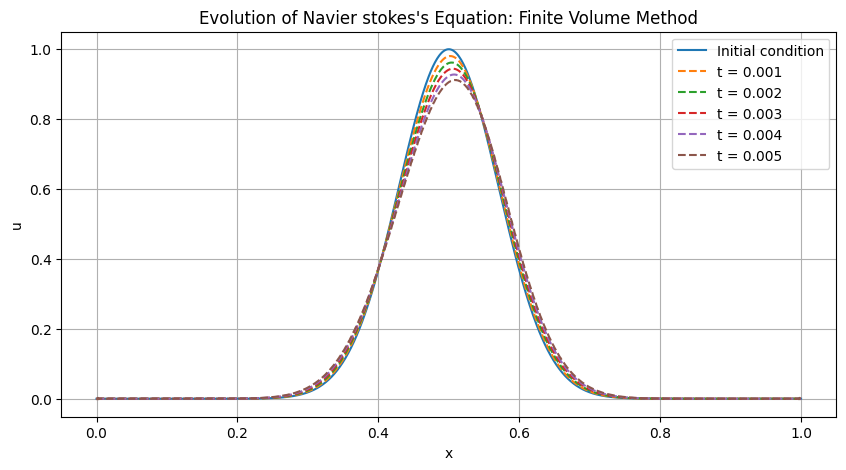

In [62]:
# Problem inputs
## Set the basic parameter
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nu = 0.1            # Viscosity

## Set the initial condition
dx = L / (nx - 1)
x, u_initial, dx = GaussionInitialize().initialize(nx, L)

u_final_1 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 1)
u_final_2 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 2)
u_final_3 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 3)
u_final_4 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 4)
u_final_5 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 5)

# Plot the initial and final solutions
def plot_results(x, u_initial):
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u_final_1, label='t = 0.001', linestyle='--')
    plt.plot(x, u_final_2, label='t = 0.002', linestyle='--')
    plt.plot(x, u_final_3, label='t = 0.003', linestyle='--')
    plt.plot(x, u_final_4, label='t = 0.004', linestyle='--')
    plt.plot(x, u_final_5, label='t = 0.005', linestyle='--')
    
    plt.title('Evolution of Navier stokes\'s Equation: Finite Volume Method')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results
plot_results(x, u_initial)

Comparison between different integrators (FVM, nt = 2)

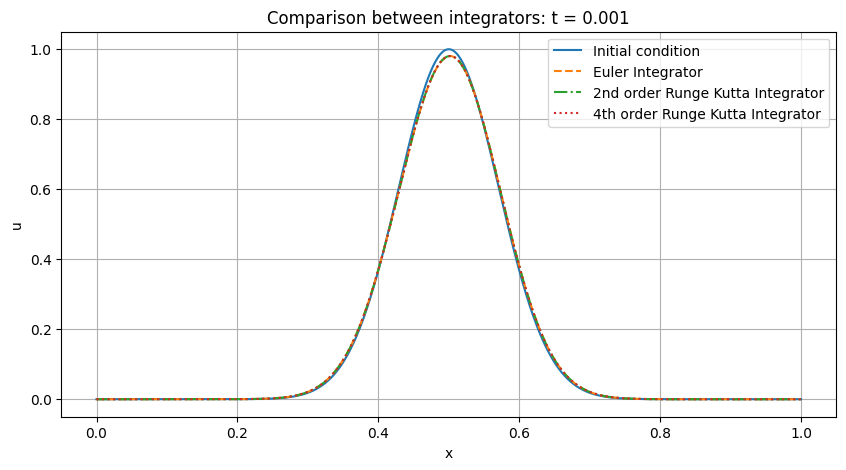

In [63]:
# Problem inputs
## Set the basic parameter
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nt = 1              # Time steps
tlim = dt * nt      # End time for simulation
nu = 0.1            # Viscosity

## Set the initial condition
dx = L / (nx - 1)
x, u_initial, dx = GaussionInitialize().initialize(nx, L)

u_final_euler = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, nt)
u_final_rk2 = RK2Integrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, nt)
u_final_rk4 = RK4Integrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, nt)

# Plot the initial and final solutions
def plot_results(x, u_initial):
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u_final_euler, label='Euler Integrator',linestyle='--')
    plt.plot(x, u_final_rk2, label='2nd order Runge Kutta Integrator', linestyle='-.')
    plt.plot(x, u_final_rk4, label='4th order Runge Kutta Integrator', linestyle=':')
    plt.title('Comparison between integrators: t = 0.001')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results
plot_results(x, u_initial)

Evolution of Kinetic energy as time increases. (avg_ke = (0.5 * u ** 2) / nx)

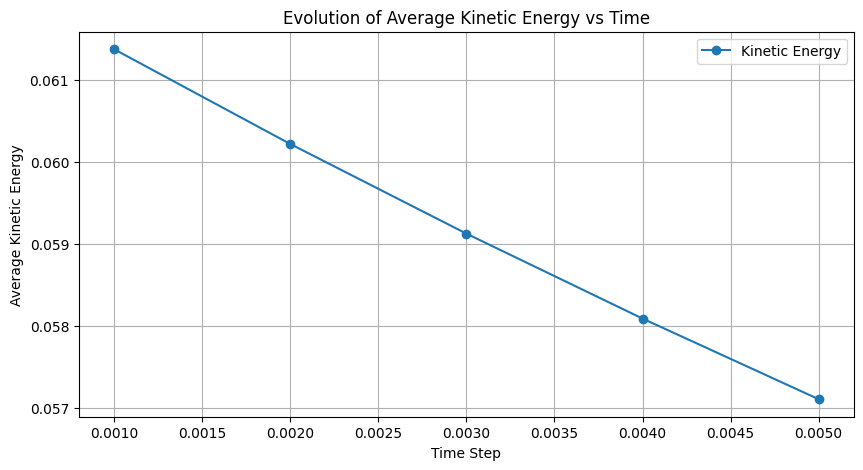

In [64]:
# Problem inputs
## Set the basic parameter
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nu = 0.1            # Viscosity

## Set the initial condition
dx = L / (nx - 1)
x, u_initial, dx = GaussionInitialize().initialize(nx, L)

# Calculate average kinetic energy
def cal_ke_avg(u: FArray, nx: int) -> float:
    energy_f = 0.5 * np.sum(u ** 2)
    return energy_f / nx

u_final_1 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 1)
ke_1 = cal_ke_avg(u_final_1, nx)
u_final_2 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 2)
ke_2 = cal_ke_avg(u_final_2, nx)
u_final_3 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 3)
ke_3 = cal_ke_avg(u_final_3, nx)
u_final_4 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 4)
ke_4 = cal_ke_avg(u_final_4, nx)
u_final_5 = EulerIntegrator().integrate(GaussionInitialize(), FVMMethod(), nx, L, nu, 5)
ke_5 = cal_ke_avg(u_final_5, nx)
time_values = 0.001 * np.array([1, 2, 3, 4, 5])
ke_values = [ke_1, ke_2, ke_3, ke_4, ke_5]

# Plot the initial and final solutions
def plot_results(time_values, ke_values):
    plt.figure(figsize=(10, 5))
    plt.plot(time_values, ke_values, marker='o', linestyle='-', label='Kinetic Energy')
    plt.title('Evolution of Average Kinetic Energy vs Time')
    plt.xlabel('Time Step')
    plt.ylabel('Average Kinetic Energy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results
plot_results(time_values, ke_values)

Evolution of the wave with sinusodal initial condition as time increases from 0 to 0.002 (FVM, EulerIntegrator)

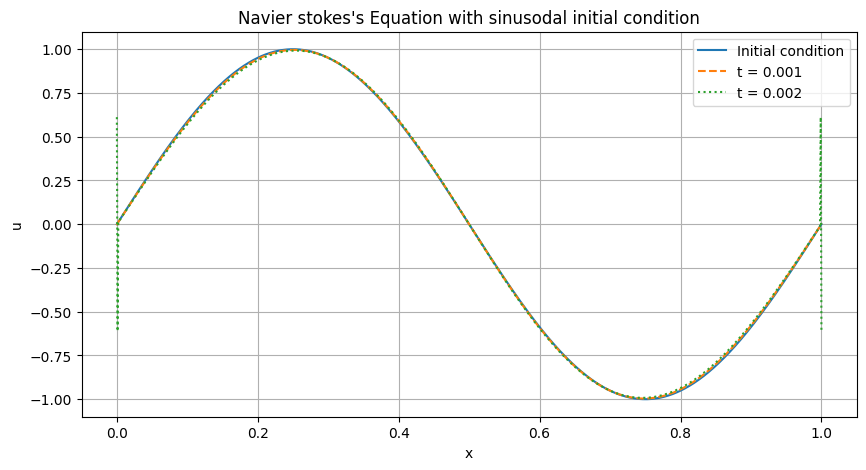

In [66]:
# Problem inputs
## Set the basic parameter
nx = 1000            # Number of spatial points
L = 1.0             # Length of the domain
dt = 0.001           # Time step size
nu = 0.1            # Viscosity

## Set the initial condition
dx = L / (nx - 1)
x, u_initial, dx = SinusoidalInitialize().initialize(nx, L)

u_final_1 = EulerIntegrator().integrate(SinusoidalInitialize(), FVMMethod(), nx, L, nu, 1)
u_final_2 = EulerIntegrator().integrate(SinusoidalInitialize(), FVMMethod(), nx, L, nu, 2)

# Plot the initial and final solutions
def plot_results(x, u_initial):
    plt.figure(figsize=(10, 5))
    plt.plot(x, u_initial, label='Initial condition')
    plt.plot(x, u_final_1, label='t = 0.001', linestyle='--')
    plt.plot(x, u_final_2, label='t = 0.002', linestyle=':')
    
    plt.title('Navier stokes\'s Equation with sinusodal initial condition')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results
plot_results(x, u_initial)